In [12]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Import and process the dataset of Roblox stock information.

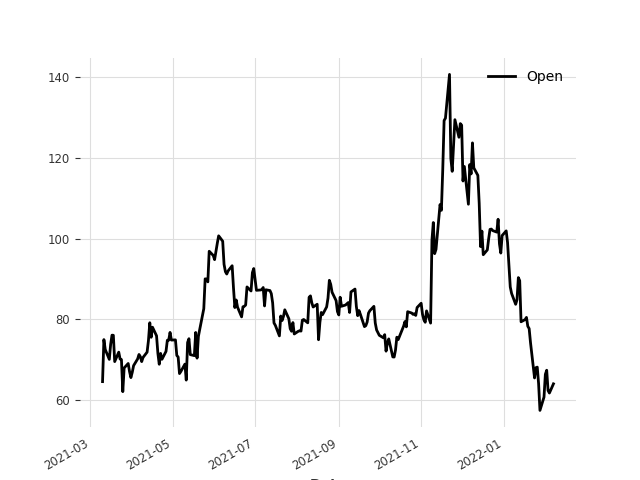

In [14]:
from os.path import abspath
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

# Read /data/RBLX.csv as a pandas dataframe
df = pd.read_csv(abspath('../../../data/Roblox/RBLX.csv'), index_col=0)

# Convert the Data column to datetime
df.index = pd.to_datetime(df.index)

series = TimeSeries.from_dataframe(df, value_cols='Open', freq='B')
series = series.astype(np.float32)

series = fill_missing_values(series, fill="auto")

# Plot the series using a line graph
series.plot()

In [15]:
from darts.dataprocessing.transformers import Scaler

# Find the timestamp of the first 80% of df
first_80_percent = df.index[int(len(df) * 0.8)]

# Create training and test sets
train, val = series.split_after(pd.Timestamp(first_80_percent))

transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [16]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.models import TFTModel

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

input_chunk_length = 48
forecast_horizon = 24

model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=50,
    add_relative_index=True,
    add_encoders={"cyclic": {"past": ["month"]}, 'datetime_attribute': {'past': ['hour', 'dayofweek']}, 'transformer': Scaler()},
    model_name = 'Roblox-PastCovariate',
    work_dir = abspath('../../../logs/RBLX-TFT-Covariant'),
    save_checkpoints = True,
    random_state=42,
    pl_trainer_kwargs={"callbacks": [stopper]}
)

In [17]:
model.fit(train_transformed, verbose=True)

Epoch 49: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s, loss=0.245]


In [18]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

Predicting: 8it [00:00, ?it/s]


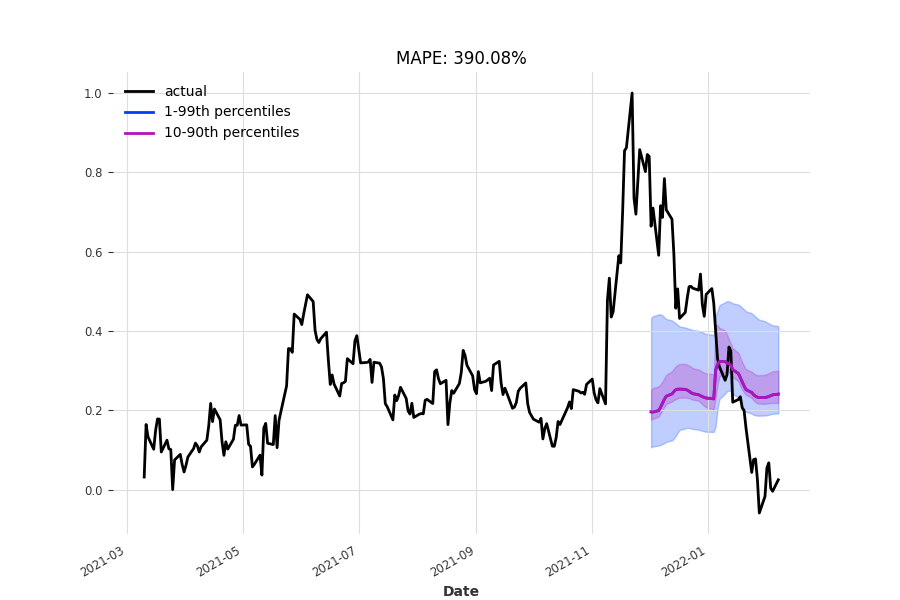

In [19]:
from darts.metrics import mape

def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=num_samples)

    # plot actual series
    plt.figure(figsize=figsize)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(model, 48, series_transformed, val_transformed)

In [20]:
backtest_series = model.historical_forecasts(
    series_transformed,
    start=train.end_time() + train.freq,
    num_samples=num_samples,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2 [00:00<?, ?it/s]

Predicting: 8it [00:00, ?it/s]
Predicting: 8it [00:00, ?it/s]


MAPE: 19.19%


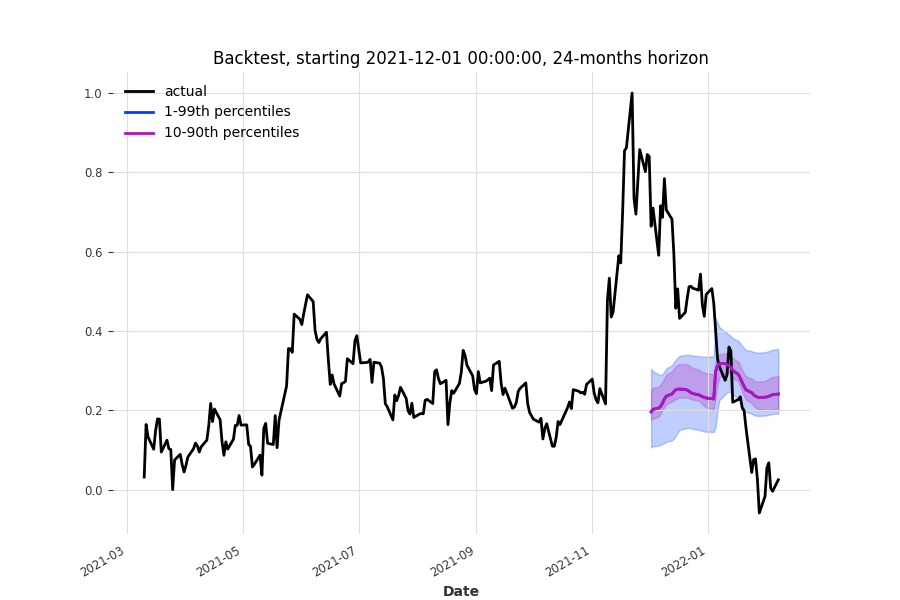

In [21]:
from darts import TimeSeries, concatenate

def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=pd.Timestamp(first_80_percent),
    transformer=transformer,
)

In [22]:
model.save_model('/Users/aditya/Programming/stock-market-predictions/logs/RBLX-TFT-Covariant/RBLX.pth.tar')

In [23]:
model.gridsearch({'hidden_size': [16, 32, 64, 128, 256], 'lstm_layers': [1, 2, 3, 4, 5], 'num_attention_heads': [1, 2, 3, 4, 5], 'dropout': [0.1, 0.2, 0.3, 0.4, 0.5]}, series=train_transformed, val_series=val_transformed, verbose=True, n_jobs=-1)

  0%|          | 0/625 [00:00<?, ?it/s]